# **Submission Project**

---



# OVERVIEW

Bengaluru adalah tempat terbaik untuk pecinta kuliner. Jumlah restoran semakin hari semakin bertambah. Saat ini yang berdiri di sekitar 12.000 restoran. Dengan jumlah restoran yang begitu tinggi. Industri ini belum jenuh. Dan restoran baru buka setiap hari. Namun menjadi sulit bagi mereka untuk bersaing dengan restoran yang sudah mapan. Dataset ini bertujuan untuk menganalisis demografi lokasi dari sebuah resto. Yang paling penting itu akan membantu restoran baru dalam menentukan tema, menu, masakan dll untuk lokasi tertentu. Ini juga bertujuan untuk menemukan kesamaan antara lingkungan Bengaluru berdasarkan makanan.

Dataset diambil dari https://www.kaggle.com/datasets/himanshupoddar/zomato-bangalore-restaurants


# IMPORT PACKAGES

In [116]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import implicit

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import re
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# READ DATASET

In [118]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [119]:
df = pd.read_csv('/content/gdrive/MyDrive/Narasio/SNS/Capstone/zomato.csv')
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


## Metadata

Berikut adalah deskripsi tiap kolom yang ada dari dataset

| Nama Kolom | Deskripsi |
| --- | --- |
|url|url resto|
|alamat|Alamat resto|
|nama|Nama resto|
|pesan_online|Pelayanan pembelian secara online|
|pesan_meja| Pelayanan pembelian meja|
|rating |Rata-rata rating resto|
|votes |Banyaknya rating yang diberikan pelanggan|
|telepon Nomor| telepon resto|
|lokasi |Lokasi resto|
|tipe_resto| Tipe resto|
|menu_favorit| Makanan yang paling disukai pelanggan|
|jenis_makanan| Jenis makanan di resto|
|dua_pelanggan| Banyaknya pelanggan yang memesan makanan untuk dua orang|
|review| Review pelanggan|
|menu| Menu di resto|
|tipe_makanan| Tipe makanan di resto|
|kota| Kota resto|

# PROBLEM STATEMENT

- Mendapatkan informasi behavior dari customer 
- Mempelajari demografi dari sebuah lokasi. Jenis makanan apa yang lebih populer di suatu daerah
- Membantu restoran baru dalam menentukan tema, menu dan masakan untuk lokasi tertentu untuk mendapatkan rekomendasi usaha kuliner apa yang sebaiknya dijalankan berdasar data yang ada

# DATA PRE-PROCESSING

## Data Understanding & Cleansing

- check data type format
- check for uniqueness
- check missing value
- check data value

### Function Data Understanding

In [120]:
def listOfItem(data):
    list_Item = []
    for col in data.columns :
        list_Item.append([col, data[col].dtype,len(data), data[col].isna().sum(),data[col][data[col]=="\\N"].count(),data[col][data[col]=="0"].count(),round((data[col].isna().sum()/len(data[col])) * 100,2),
                        data[col].nunique()])

    dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType','Raw','missingValue','Nan(\\N) Value','Nol (0) Value','missingValue_Pct', 'uniqueValue'],
                        data=list_Item)
    return dfDesc

#### Analisa data

In [121]:
print("Dari hasil cheking ditemukan analisa sebagai berikut :"); 
listOfItem(df)

Dari hasil cheking ditemukan analisa sebagai berikut :


,dataFeatures,dataType,Raw,missingValue,Nan(\N) Value,Nol (0) Value,missingValue_Pct,uniqueValue
0,url,object,51717,0,0,0,0.00,51717
1,address,object,51717,0,0,0,0.00,11495
2,name,object,51717,0,0,0,0.00,8792
3,online_order,object,51717,0,0,0,0.00,2
4,book_table,object,51717,0,0,0,0.00,2
5,rate,object,51717,7775,0,0,15.03,64
6,votes,int64,51717,0,0,0,0.00,2328
7,phone,object,51717,1208,0,0,2.34,14926
8,location,object,51717,21,0,0,0.04,93
9,rest_type,object,51717,227,0,0,0.44,93


<b>Missing Value</b>

- Ada missing value pada kolom **rate**, namun dibiarkan karena bisa jadi restoran belum memiliki rata-rata rating
- Kolom **phone** ada missing value, tidak perlu dilakukan treatment karena asumsi lestoran hanya menerima pembelian dinein(tidak online order) sehingga tidak perlu memasang informasi nomor telp.
- Ada missing value pada **location**, hal ini perlu dikakukan drop missing value **(Dropna)**, karena setiap resto asumsi memiliki alamat
- **rest_type** ditemukan missing value, perlu dikakukan drop missing value **(Dropna)**
- **dish_liked** ditemukan missing value, perlu dikakukan drop missing value **(Dropna)**
- **cuisines ** ditemukan missing value, perlu dikakukan drop missing value **(Dropna)**
- **approx_cost(for two people)**	 ditemukan missing value, tidak perlu dikakukan drop missing value karena bisa jadi banyaknya pelanggan yang memesan makanan untuk dua orang tidak ada
- Pada kolom rate tipe data masih object, perlu dilakukan perubahan tipe data


##Data Preparation

### Data Cleansing Null Value

In [122]:
def datanotnull(datasourcer,column):
    dataset = datasourcer.dropna(subset=column)
    return dataset

In [123]:
dataset = datanotnull(df,["location","rest_type","dish_liked","cuisines"])

In [124]:
print("Data setelah di cleansing"); 
listOfItem(dataset)

Data setelah di cleansing


,dataFeatures,dataType,Raw,missingValue,Nan(\N) Value,Nol (0) Value,missingValue_Pct,uniqueValue
0,url,object,23569,0,0,0,0.00,23569
1,address,object,23569,0,0,0,0.00,4413
2,name,object,23569,0,0,0,0.00,3185
3,online_order,object,23569,0,0,0,0.00,2
4,book_table,object,23569,0,0,0,0.00,2
5,rate,object,23569,30,0,0,0.13,63
6,votes,int64,23569,0,0,0,0.00,2308
7,phone,object,23569,337,0,0,1.43,6812
8,location,object,23569,0,0,0,0.00,88
9,rest_type,object,23569,0,0,0,0.00,73


### Data Cleansing Anomaly

####Hapus data duplicated

In [125]:
#Hapus data duplicated
dfresto = dataset.drop_duplicates()

In [126]:
dfresto.shape

(23569, 17)

In [127]:
dfresto.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


#### Merapikan Kolom Dataset

#####Rubah nama kolom agar lebih rapih

In [128]:
#Nama kolom perlu di rename agar lebih rapih
dfresto = dfresto.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type',
                                  'listed_in(city)':'city'})
dfresto.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines', 'cost',
       'reviews_list', 'menu_item', 'type', 'city'],
      dtype='object')

#####Rubah tipe data yang sesuai

In [129]:
dfresto['cost'] = dfresto['cost'].astype(str) 
dfresto['cost'] = dfresto['cost'].apply(lambda x: x.replace(',','.'))
dfresto['cost'] = dfresto['cost'].astype(float)
dfresto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23569 entries, 0 to 51715
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           23569 non-null  object 
 1   address       23569 non-null  object 
 2   name          23569 non-null  object 
 3   online_order  23569 non-null  object 
 4   book_table    23569 non-null  object 
 5   rate          23539 non-null  object 
 6   votes         23569 non-null  int64  
 7   phone         23232 non-null  object 
 8   location      23569 non-null  object 
 9   rest_type     23569 non-null  object 
 10  dish_liked    23569 non-null  object 
 11  cuisines      23569 non-null  object 
 12  cost          23435 non-null  float64
 13  reviews_list  23569 non-null  object 
 14  menu_item     23569 non-null  object 
 15  type          23569 non-null  object 
 16  city          23569 non-null  object 
dtypes: float64(1), int64(1), object(15)
memory usage: 3.2+ MB


#####Removing '/5' from Rates

In [130]:
dfresto = dfresto.loc[dfresto.rate !='NEW']
dfresto = dfresto.loc[dfresto.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
dfresto.rate = dfresto.rate.apply(remove_slash).str.strip().astype('float')
dfresto['rate'].head() 

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [131]:
dfresto.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


##Univariate Data Analys

Meneliti distribusi rating dari rating dataframe dengan Barplot

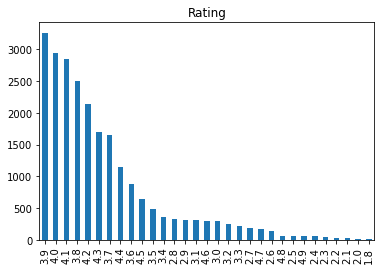

In [132]:
count = dfresto["rate"].value_counts()
count.plot(kind='bar', title="Rating");
 
plt.show()

## Multivariate Analysis

Melihat pairplot yang ada pada rating dataset

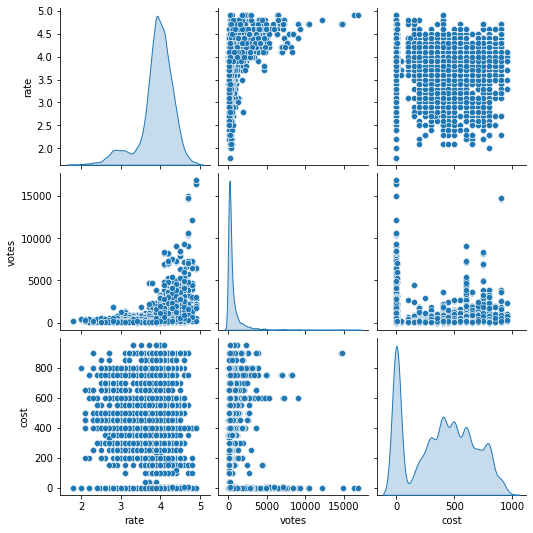

In [133]:
sns.pairplot(dfresto, diag_kind = 'kde')

#EDA

### Customer Behavior

In [ ]:
dfresto.groupby(['online_order','book_table','location','rest_type','city']).agg({
    'name':lambda x:x.nunique()
}).sort_values('online_order', ascending=False)

####Onine VS Offline Order

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
countdfresto = dfresto['online_order'].value_counts()
colors = sns.color_palette('pastel')
countdfresto.plot.pie(explode=[0,0.1], autopct='%1.1f%%', shadow=True, colors=colors).set_title('Online Order?')
ax.set_ylabel('')
plt.show()

Sebanyak 70 persen customer lebih memilih order secara online dan sisanya offline

In [ ]:
dfresto.groupby(['rest_type','online_order'])['name'].nunique().sort_values(ascending=False).head(10)

####Book Table Vs No

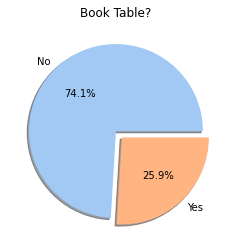

In [ ]:
f,ax = plt.subplots(1,1,figsize=(12,4))
countdfresto = dfresto['book_table'].value_counts()
colors = sns.color_palette('pastel')
countdfresto.plot.pie(explode=[0,0.1], autopct='%1.1f%%', shadow=True, colors=colors).set_title('Book Table?')
ax.set_ylabel('')
plt.show()

Dari grafik dapat dilihat behavior customer lebih banyak yang pesan tanpa booking table terlebih dahulu

####Customer Order Behavior By Restoran Type

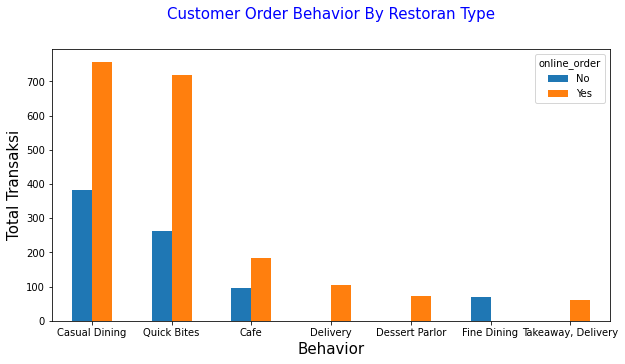

In [ ]:
dfresto.groupby(['rest_type','online_order'])['name'].nunique().sort_values(ascending=False).head(10).unstack().plot(kind='bar')
plt.title('Customer Order Behavior By Restoran Type',loc='center',pad=30,fontsize=15,color='blue')
plt.xlabel('Behavior',fontsize=15)
plt.ylabel('Total Transaksi',fontsize=15)
plt.ylim(ymin=0)
labels,location = plt.yticks()
plt.xticks(rotation=0)
plt.gcf().set_size_inches(10,5)
plt.show()

Secara keseluruhan Dari grafik dapat dilihat customer lebih banyak melakukan pembelian secara online sebanyak 69.2% dibanding offline sekitar 30.8 %, dan tipe restoran paling banyak disukai yaitu **Casual Dining**  kemudian disusul dengan **Quick Bites, Cafe dan Delivery.** 

####Customer Order Offline dilihat dari Tipe Restoran

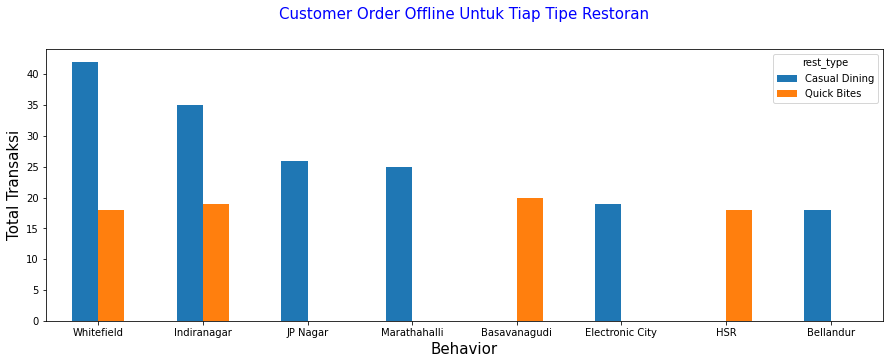

In [ ]:
dfresto[dfresto["online_order"]=="No"].groupby(['location','rest_type'])['name'].nunique().sort_values(ascending=False).head(10).unstack().plot(kind='bar')
plt.title('Customer Order Offline Untuk Tiap Tipe Restoran',loc='center',pad=30,fontsize=15,color='blue')
plt.xlabel('Behavior',fontsize=15)
plt.ylabel('Total Transaksi',fontsize=15)
plt.ylim(ymin=0)
labels,location = plt.yticks()
plt.xticks(rotation=0)
plt.gcf().set_size_inches(15,5)
plt.show()

Customer yang melakukan pembelian offline paling banyak berada di daerah **Whitefield,  Indiranagar,  JP Nagar, Marathalli dan Basavanaguni** dengan tipe restoran paling banyak adalah **Casual Dinning**

#### Customer Order Online dilihat dari Tipe Restoran

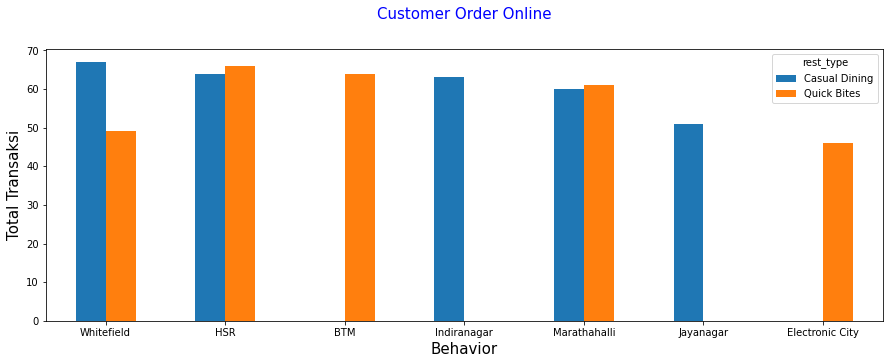

In [ ]:
dfresto[dfresto["online_order"]=="Yes"].groupby(['location','rest_type'])['name'].nunique().sort_values(ascending=False).head(10).unstack().plot(kind='bar')
plt.title('Customer Order Online',loc='center',pad=30,fontsize=15,color='blue')
plt.xlabel('Behavior',fontsize=15)
plt.ylabel('Total Transaksi',fontsize=15)
plt.ylim(ymin=0)
labels,location = plt.yticks()
plt.xticks(rotation=0)
plt.gcf().set_size_inches(15,5)
plt.show()

Customer yang melakukan pembelian online paling banyak berada di daerah **Whitefield, HSR, Indiranagar, BTM dan Marathalli** Dengan tipe restoran di dominasi oleh **Casual Dinning dan Quiq Bites**

####Food Type

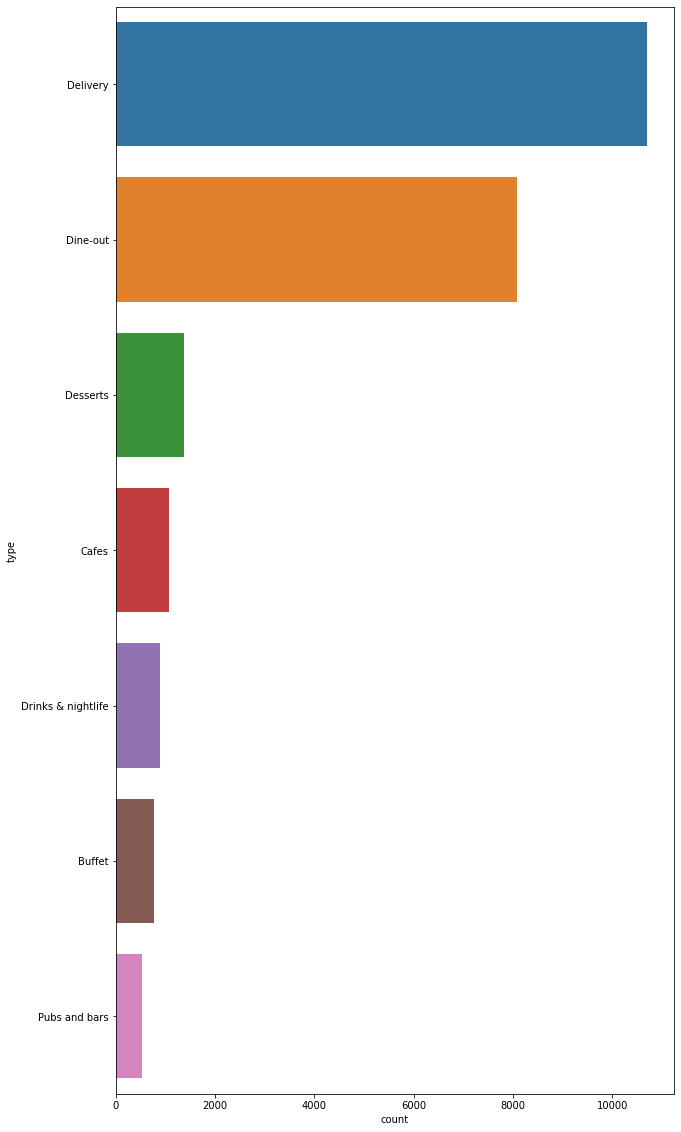

In [ ]:
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(1,1,1)
sns.countplot(y=dfresto['type'],ax=ax1,order = dfresto['type'].value_counts(ascending=False).index)

Customer paling sering melakukan delivery order

### Restorant Demografi

####Distribution of Location

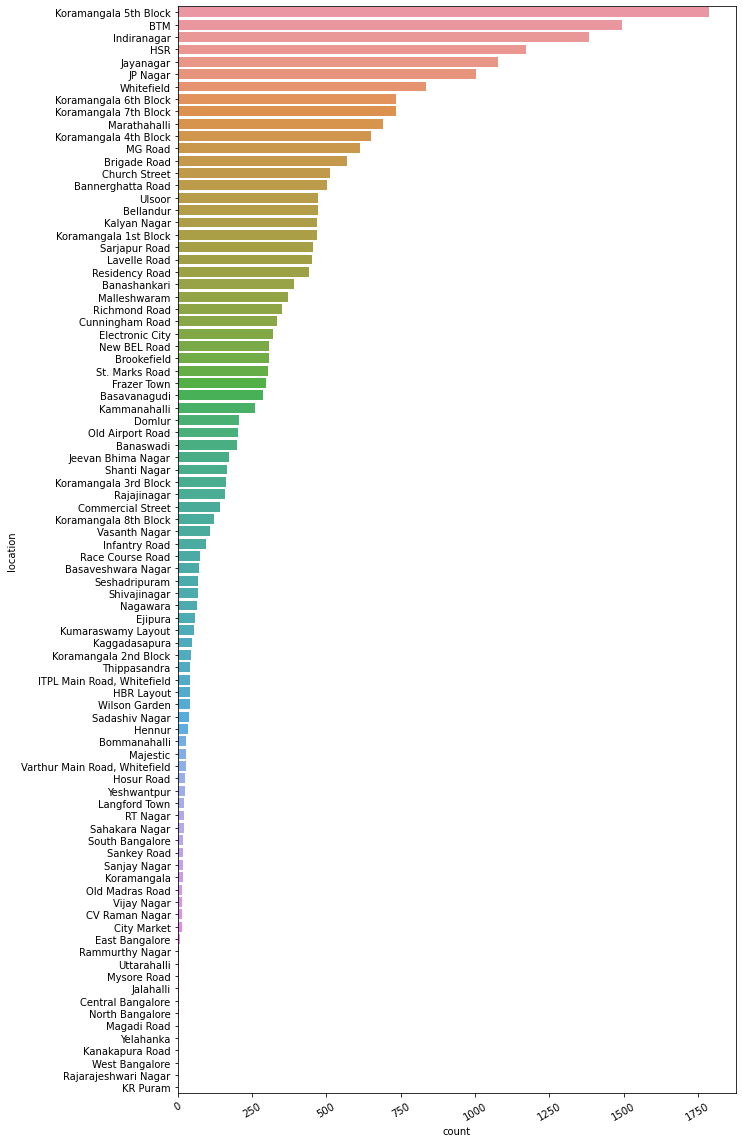

In [ ]:
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(1,1,1)
sns.countplot(y=dfresto['location'],ax=ax1,order = dfresto['location'].value_counts(ascending=False).index)
p = plt.xticks(rotation=30)

Customer membeli paling banyak di 3 lokasi yaitu Koramangala 5th Blovk,BTM dan indiranagar

####City Distribution

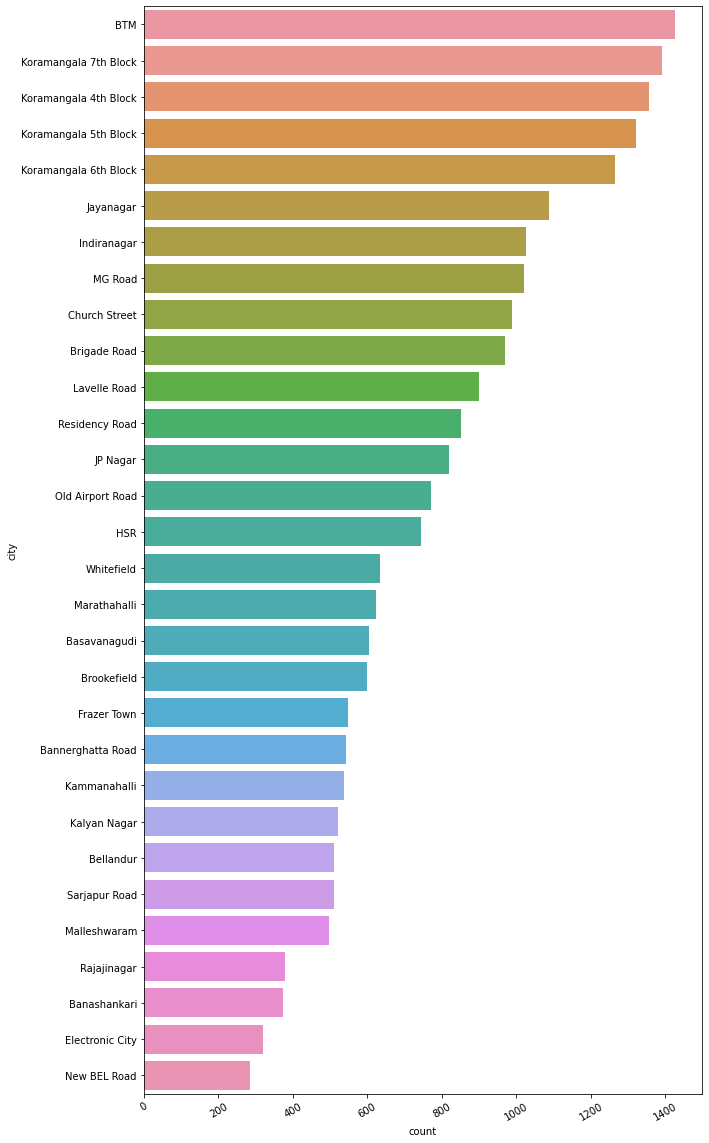

In [ ]:
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(1,1,1)
sns.countplot(y=dfresto['city'],ax=ax1,order = dfresto['city'].value_counts(ascending=False).index)
p = plt.xticks(rotation=30)

Persebaran pembelian customer pada resto di 3 kota terbanyak yaitu di BTM, Koromangala 7th Block, Koromangala 4th Block

In [ ]:
dfresto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23422 entries, 0 to 23421
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           23422 non-null  object 
 1   address       23422 non-null  object 
 2   name          23422 non-null  object 
 3   online_order  23422 non-null  object 
 4   book_table    23422 non-null  object 
 5   rate          23392 non-null  float64
 6   votes         23422 non-null  int64  
 7   phone         23085 non-null  object 
 8   location      23422 non-null  object 
 9   rest_type     23422 non-null  object 
 10  dish_liked    23422 non-null  object 
 11  cuisines      23422 non-null  object 
 12  cost          23288 non-null  float64
 13  reviews_list  23422 non-null  object 
 14  menu_item     23422 non-null  object 
 15  type          23422 non-null  object 
 16  city          23422 non-null  object 
dtypes: float64(2), int64(1), object(14)
memory usage: 3.0+ MB


####Semua Distribusi Tipe Lestoran 

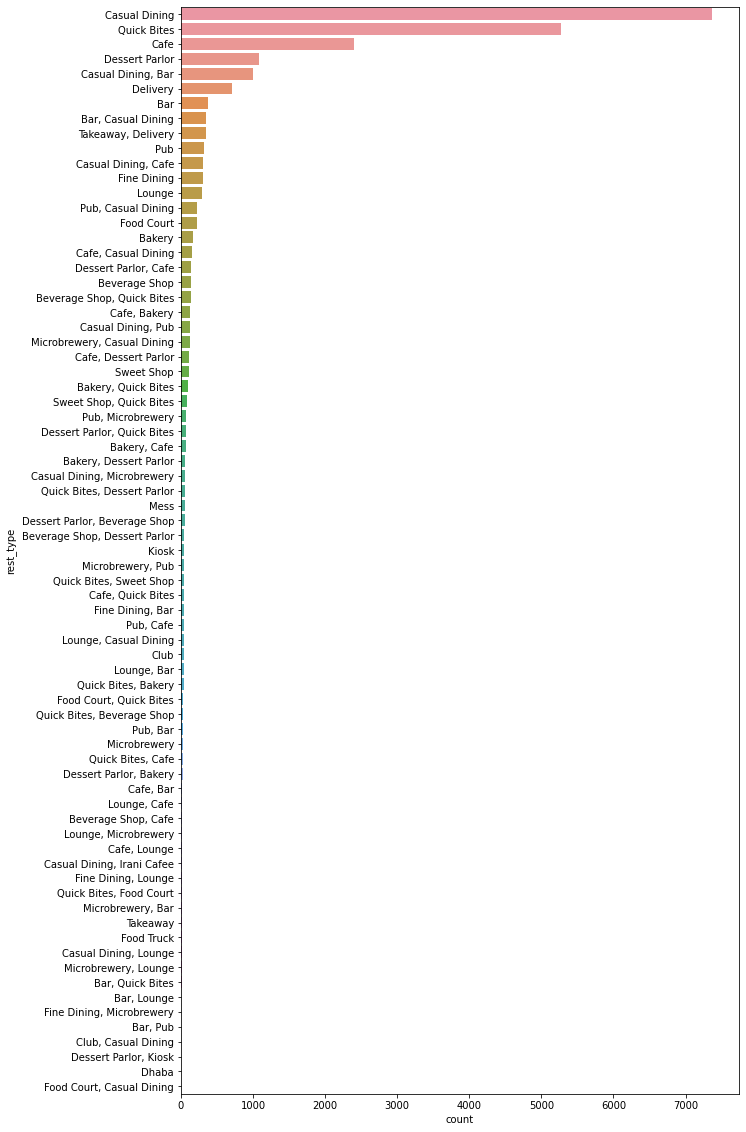

In [ ]:
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(1,1,1)
sns.countplot(y=dfresto['rest_type'],ax=ax1,order = dfresto['rest_type'].value_counts(ascending=False).index)

Customer paling banyak membeli pada Resto tipe Casual Dinning, Quiq bites dam cafe dilihat dari semua total pembelian pada tiap resto

###Rating Resto Per City

In [ ]:
dfresto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23422 entries, 0 to 23421
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           23422 non-null  object 
 1   address       23422 non-null  object 
 2   name          23422 non-null  object 
 3   online_order  23422 non-null  object 
 4   book_table    23422 non-null  object 
 5   rate          23392 non-null  float64
 6   votes         23422 non-null  int64  
 7   phone         23085 non-null  object 
 8   location      23422 non-null  object 
 9   rest_type     23422 non-null  object 
 10  dish_liked    23422 non-null  object 
 11  cuisines      23422 non-null  object 
 12  cost          23288 non-null  float64
 13  reviews_list  23422 non-null  object 
 14  menu_item     23422 non-null  object 
 15  type          23422 non-null  object 
 16  city          23422 non-null  object 
dtypes: float64(2), int64(1), object(14)
memory usage: 3.0+ MB


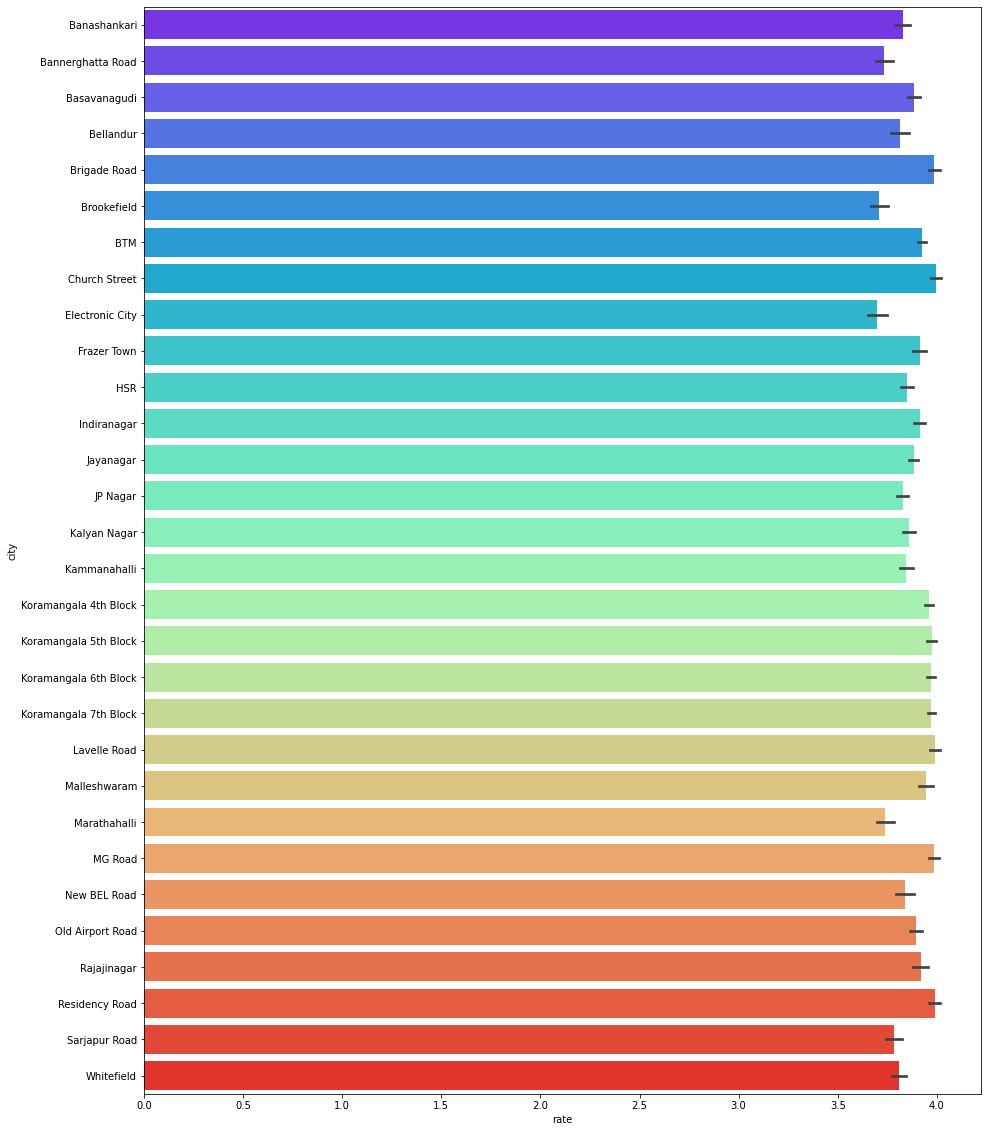

In [ ]:
fig = plt.figure(figsize=(15,20))
ax1 = fig.add_subplot(1,1,1)
sns.barplot(x='rate', y='city', data=dfresto,palette='rainbow',ax=ax1);

###Voting Resto per City

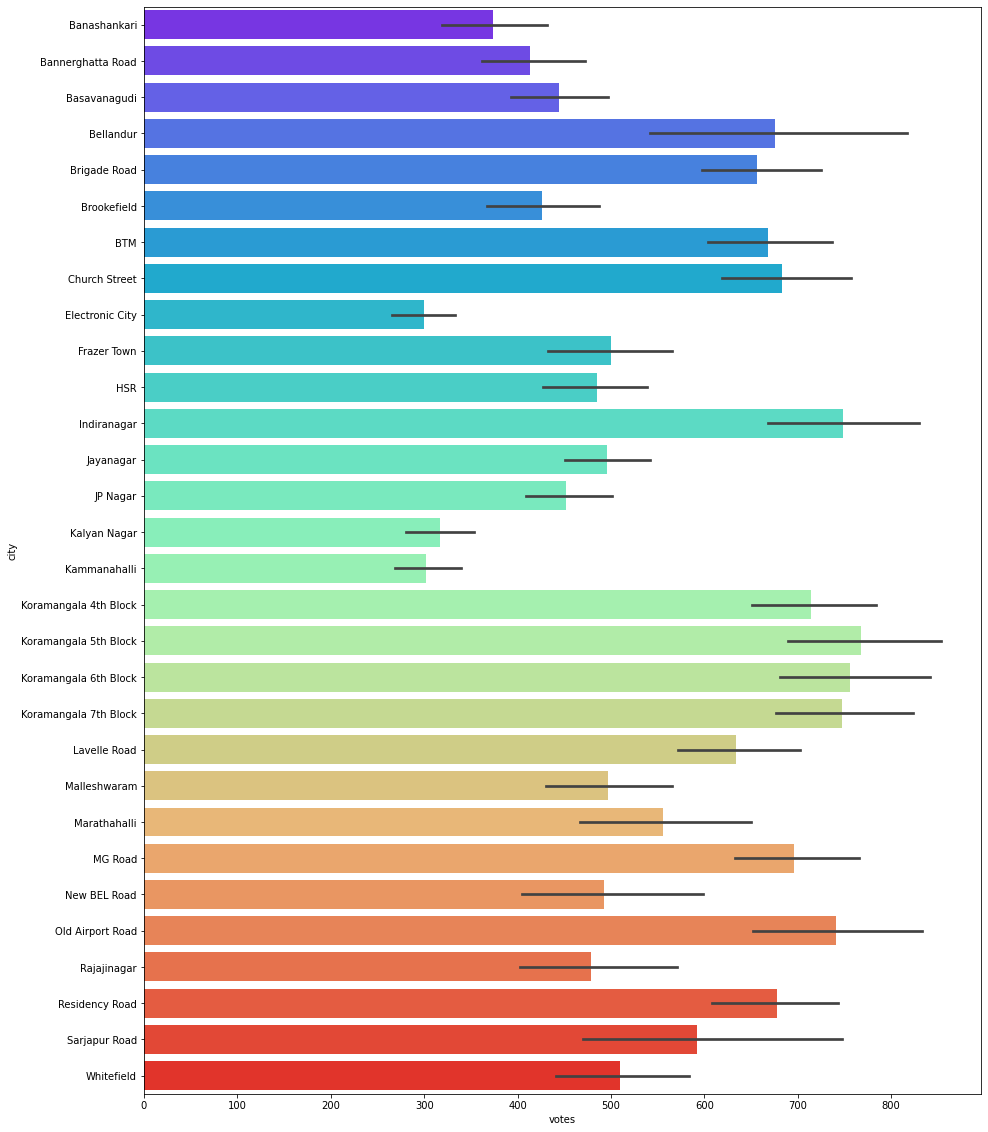

In [ ]:
fig = plt.figure(figsize=(15,20))
ax1 = fig.add_subplot(1,1,1)
sns.barplot(x='votes', y='city', data=dfresto,palette='rainbow',ax=ax1);

# MODELING

##Content Filtered Recommendation System

Content Based Filtering adalah sistem rekomendasi yang merekomendasikan item sesuai dengan item yang disukai oleh pengguna di masa lampau.

Content Based mempelajari profil dan perilaku dari pengguna yang kemudian dari informasi tersebut dianalisa dan diproses sehingga menghasilkan sistem rekomendasi yang baik. Semakin banyak informasi yang diberikan ke sistem ini, maka sistem rekomendasi berbasis content based akan memiliki akurasi yang lebih baik.

**Tujuan dari projek ini  adalah membuat sistem pemberi rekomendasi berbasis konten di mana ketika user akan menulis nama restoran, sistem Rekomendasi akan melihat ulasan restoran lain, dan Sistem akan merekomendasikan kepada user restoran lain dengan ulasan serupa dan mengurutkannya dari peringkat tertinggi.**

####FEATURE ENGINEERING

In [134]:
resto=dfresto.drop(['url','dish_liked','phone'],axis=1)

###Data Preparation

####Data Cleansing

In [135]:
#Removing the Duplicates
resto.duplicated().sum()
resto.drop_duplicates(inplace=True)

In [136]:
#Remove the NaN values from the dataset
resto.isnull().sum()
resto.dropna(how='any',inplace=True)
resto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23248 entries, 0 to 23421
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   address       23248 non-null  object 
 1   name          23248 non-null  object 
 2   online_order  23248 non-null  object 
 3   book_table    23248 non-null  object 
 4   rate          23248 non-null  float64
 5   votes         23248 non-null  int64  
 6   location      23248 non-null  object 
 7   rest_type     23248 non-null  object 
 8   cuisines      23248 non-null  object 
 9   cost          23248 non-null  float64
 10  reviews_list  23248 non-null  object 
 11  menu_item     23248 non-null  object 
 12  type          23248 non-null  object 
 13  city          23248 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 2.7+ MB


In [137]:
#Some Transformations
resto['cost'] = resto['cost'].astype(str) #Changing the cost to string
resto['cost'] = resto['cost'].apply(lambda x: x.replace(',','.')) #Using lambda function to replace ',' from cost
resto['cost'] = resto['cost'].astype(float) # Changing the cost to Float
resto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23248 entries, 0 to 23421
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   address       23248 non-null  object 
 1   name          23248 non-null  object 
 2   online_order  23248 non-null  object 
 3   book_table    23248 non-null  object 
 4   rate          23248 non-null  float64
 5   votes         23248 non-null  int64  
 6   location      23248 non-null  object 
 7   rest_type     23248 non-null  object 
 8   cuisines      23248 non-null  object 
 9   cost          23248 non-null  float64
 10  reviews_list  23248 non-null  object 
 11  menu_item     23248 non-null  object 
 12  type          23248 non-null  object 
 13  city          23248 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 2.7+ MB


In [138]:
#Reading Rate of dataset
resto['rate'].unique()

array([4.1, 3.8, 3.7, 4.6, 4. , 4.2, 3.9, 3. , 3.6, 2.8, 4.4, 3.1, 4.3,
       2.6, 3.3, 3.5, 3.2, 4.5, 2.5, 2.9, 3.4, 2.7, 4.7, 2.4, 2.2, 2.3,
       4.8, 4.9, 2.1, 2. , 1.8])

In [139]:
resto = resto.loc[resto.rate !='NEW']
resto = resto.loc[resto.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
resto['rate'] = resto['rate'].astype(float)
resto['rate'].head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [140]:
# Adjust the column names
resto.name = resto.name.apply(lambda x:x.title())
resto.online_order.replace(('Yes','No'),(True, False),inplace=True)
resto.book_table.replace(('Yes','No'),(True, False),inplace=True)
resto.cost.unique()

array([800.  , 300.  , 600.  , 700.  , 550.  , 500.  , 450.  , 650.  ,
       400.  , 750.  , 200.  , 850.  ,   1.2 , 150.  , 350.  , 250.  ,
         1.5 ,   1.3 ,   1.  , 100.  , 900.  ,   1.1 ,   1.6 , 950.  ,
       230.  ,   1.7 ,   1.35,   2.2 ,   1.4 ,   2.  ,   1.8 ,   1.9 ,
       180.  , 330.  ,   2.5 ,   2.1 ,   3.  ,   2.8 ,   3.4 ,  40.  ,
         1.25,   3.5 ,   4.  ,   2.4 ,   1.45,   3.2 ,   6.  ,   1.05,
         4.1 ,   2.3 , 120.  ,   2.6 ,   5.  ,   3.7 ,   1.65,   2.7 ,
         4.5 ])

In [141]:
## Checking Null values
resto.isnull().sum()

address         0
name            0
online_order    0
book_table      0
rate            0
votes           0
location        0
rest_type       0
cuisines        0
cost            0
reviews_list    0
menu_item       0
type            0
city            0
dtype: int64

In [142]:
## Computing Mean Rating
restaurants = list(resto['name'].unique())
resto['Mean Rating'] = 0

for i in range(len(restaurants)):
    resto['Mean Rating'][resto['name'] == restaurants[i]] = resto['rate'][resto['name'] == restaurants[i]].mean()

In [143]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (1,5))

resto[['Mean Rating']] = scaler.fit_transform(resto[['Mean Rating']]).round(2)

resto.sample(3)

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city,Mean Rating
9934,"305, Anand NR Onyx, 15th Cross, 100 Feet Ring ...",Woodee Pizza,True,False,2.7,85,JP Nagar,Cafe,"Cafe, Pizza, Fast Food, Beverages",500.0,"[('Rated 1.0', ""RATED\n When you try to lure ...","['Margherita Pizza [6 inches]', 'Glazed Onion ...",Delivery,JP Nagar,2.36
10947,"582, 5th Main Road, St Thomas Town, Inasappa L...",Jingo Bbq & Burgers,True,False,3.9,41,Kammanahalli,Quick Bites,"Burger, BBQ",550.0,"[('Rated 3.0', 'RATED\n Randomly one Saturday...","['Fiery Chicken Burger', 'Old Monk Chicken Bur...",Dine-out,Kalyan Nagar,3.71
7829,"148 /149, St Thomas Building, Brigade Road, Ba...",Laughing Llama Gastropub,True,True,4.3,389,Brigade Road,"Bar, Casual Dining","Finger Food, Continental, Pizza",1.6,"[('Rated 4.0', 'RATED\n Loooove the music her...",[],Delivery,Indiranagar,4.16


#### Text Cleansing

- Lower casing
- Removal of Punctuations
- Removal of Stopwords
- Removal of URLs
- Spelling correction

In [144]:
# 5 examples of these columns before text processing:
resto[['reviews_list', 'cuisines']].sample(5)

,reviews_list,cuisines
19297,[],"Biryani, North Indian"
18493,"[('Rated 2.0', ""RATED\n Tried their chicken b...","North Indian, Chinese"
12725,"[('Rated 1.0', 'RATED\n Dont even deserve for...","Salad, Biryani, Chinese, North Indian, Kerala,..."
13151,"[('Rated 4.0', ""RATED\n There was a time, whe...","Biryani, Chinese, Mughlai, Fast Food, Kebab"
2300,"[('Rated 1.0', 'RATED\n This place is bad ver...","Cafe, Italian, Continental, Beverages"


In [145]:
## Lower Casing
resto["reviews_list"] = resto["reviews_list"].str.lower()
resto[['reviews_list', 'cuisines']].sample(5)

,reviews_list,cuisines
16170,"[('rated 3.0', 'rated\n the ice cream served ...","Desserts, Cafe, Fast Food"
5055,"[('rated 4.0', ""rated\n we had sunday lunch b...","Italian, North Indian, Lebanese"
6859,"[('rated 4.0', 'rated\n had a great time here...","Finger Food, Continental, North Indian"
22996,"[('rated 4.0', 'rated\n went here for saturda...","Biryani, North Indian, Kebab"
19796,"[('rated 4.0', ""rated\n namaste !\nwe recentl...","North Indian, Pizza, Chinese"


In [146]:
## Removal of Puctuations
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

resto["reviews_list"] = resto["reviews_list"].apply(lambda text: remove_punctuation(text))
resto[['reviews_list', 'cuisines']].sample(5)

,reviews_list,cuisines
10606,rated 30 ratedn i visited this place for dinn...,"Cafe, Continental, Italian, Burger, Pizza, Sal..."
18211,rated 40 ratedn another pub on new bel road w...,"Continental, Finger Food, North Indian, Chinese"
19471,rated 50 ratedn love how lively this place is...,"North Indian, Chinese, Continental, Italian"
4965,rated 40 ratedn well we went there to celebra...,"Continental, American, North Indian, Chinese"
15654,rated 40 ratedn i chose to sit at the outlet ...,Healthy Food


In [147]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [148]:
## Removal of Stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

resto["reviews_list"] = resto["reviews_list"].apply(lambda text: remove_stopwords(text))

In [149]:
## Removal of URLS
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

resto["reviews_list"] = resto["reviews_list"].apply(lambda text: remove_urls(text))

In [150]:
resto[['reviews_list', 'cuisines']].sample(5)

,reviews_list,cuisines
12688,rated 50 ratedn best place donne biryani lover...,Biryani
18714,rated 40 ratedn bong try place went sunday lun...,Bengali
8034,rated 40 ratedn spicy lover visit hear service...,"Andhra, South Indian, North Indian"
20906,rated 40 ratedn great ambiencenbreakfast buffe...,"North Indian, Chinese, Continental"
19790,rated 40 ratedn favourite pub city theres some...,"American, Finger Food, BBQ, Steak"


In [151]:
# RESTAURANT NAMES:
restaurant_names = list(resto['name'].unique())
restaurant_names

['Jalsa',
 'Spice Elephant',
 'San Churro Cafe',
 'Addhuri Udupi Bhojana',
 'Grand Village',
 'Timepass Dinner',
 'Onesta',
 'Penthouse Cafe',
 'Smacznego',
 'Cafã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â© Down The Alley',
 'Cafe Shuffle',
 'The Coffee Shack',
 'Caf-Eleven',
 'Cafe Vivacity',
 'Catch-Up-Ino',
 "Kirthi'S Biryani",
 'T3H Cafe',
 'The Vintage Cafe',
 'Woodee Pizza',
 'My Tea House',
 "Srinathji'S Cafe",
 'Redberrys',
 'Foodiction',
 'Ovenstory Pizza',
 'Faasos',
 'Behrouz Biryani',
 'Szechuan Dragon',
 'Empire Restaurant',
 'Chaatimes',
 "Mcdonald'S",
 "Domino'S Pizza",
 'Hotboxit',
 'Kitchen Garden',
 'Recipe',
 'Beijing Bites',
 'Tasty Bytes',
 'Corner House Ice Cream',
 'Biryanis And More',
 'Roving Feast',
 'Freshmenu',
 'Wamama',
 'Peppy Peppers',
 'Goa 0 Km',
 '1947',
 'Kabab Magic',
 'Gustoes Beer House',
 'The Biryani Cafe',
 'Rolls On Wheels',
 'Sri Guru Kottureshwara Davangere Benne Dosa',
 'Upahar Sagar',
 'Frozen Bottle',
 'Me

In [152]:
def get_top_words(column, top_nu_of_words, nu_of_word):
    
    vec = CountVectorizer(ngram_range= nu_of_word, stop_words='english')
    
    bag_of_words = vec.fit_transform(column)
    
    sum_words = bag_of_words.sum(axis=0)
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:top_nu_of_words]

In [153]:
resto.shape

(23248, 15)

In [154]:
resto=resto.drop(['address','rest_type', 'type', 'menu_item', 'votes'],axis=1)

In [155]:
import pandas

# Randomly sample 60% of dataframe
df_percent = resto.sample(frac=0.5)

In [156]:
df_percent.shape

(11624, 10)

In [157]:
df_percent.head()

,name,online_order,book_table,rate,location,cuisines,cost,reviews_list,city,Mean Rating
5660,Xpress Biryani,True,False,4.3,Ulsoor,"Biryani, North Indian, Kebab",650.0,rated 40 ratedn nice place good variety veg no...,Church Street,4.23
5997,Barbeque Nation,False,True,4.3,Electronic City,"North Indian, European, Mediterranean, BBQ, Kebab",1.6,rated 30 ratedn visited place several times in...,Electronic City,4.52
6169,Food Ras,True,True,4.3,Electronic City,"North Indian, Chinese, Japanese, European, Sea...",900.0,rated 30 ratedn would loved place 4 rating fou...,Electronic City,4.23
11169,Aqni,True,False,3.9,HBR Layout,"North Indian, Mughlai, Biryani, Rolls",650.0,rated 50 ratedn yum mutton biryani ever eatenn...,Kammanahalli,3.54
17412,Roomali,False,True,4.0,Church Street,North Indian,1.3,rated 40 ratedn food delicious left us wanting...,Lavelle Road,3.84


### Modeling

Pada content Based Filtering, kita akan menggunakan TF-IDF Vectorizer.

TF-IDF yang merupakan kepanjangan dari Term Frequency-Inverse Document Frequency memiliki fungsi untuk mengukur seberapa pentingnya suatu kata terhadap kata - kata lain dalam dokumen.
Kita umumnya menghitung skor untuk setiap kata untuk menandakan pentingnya dalam dokumen dan corpus. Metode sering digunakan dalam Information Retrieval dan Text Mining.

In [158]:
df_percent.set_index('name', inplace=True)

In [159]:
indices = pd.Series(df_percent.index)

Kemudian kita akan lakukan fit dan transformasi ke dalam matriks, pada code di bawah ini, matriks tersebut adalah tfidf_matrix

In [160]:
# Creating tf-idf matrix
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_percent['reviews_list'])

In [161]:
tfidf_matrix.shape 

(11624, 1153809)

Pada tfidf_matrix terdapat 11624 ukuran data dan 1161596 reviews_list


Dalam sistem rekomendasi, kita perlu mencari cara supaya item yang kita rekomendasikan tidak terlalu jauh dari data pusat, oleh karena itu kita butuh derajat kesamaan pada item, dalam proyek ini, resto dengan derajat kesamaan antar resto dengan cosine similarity

In [162]:
#cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [163]:
from sklearn.metrics.pairwise import cosine_similarity
 
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.04600846, 0.08654804, ..., 0.02919184, 0.03873888,
        0.0309558 ],
       [0.04600846, 1.        , 0.0764605 , ..., 0.03021607, 0.04332757,
        0.03201552],
       [0.08654804, 0.0764605 , 1.        , ..., 0.06401534, 0.05122303,
        0.0361592 ],
       ...,
       [0.02919184, 0.03021607, 0.06401534, ..., 1.        , 0.01801253,
        0.02368444],
       [0.03873888, 0.04332757, 0.05122303, ..., 0.01801253, 1.        ,
        0.05808649],
       [0.0309558 , 0.03201552, 0.0361592 , ..., 0.02368444, 0.05808649,
        1.        ]])

In [164]:
# HERE IS A RANDOM RESTAURANT. LET'S SEE THE DETAILS ABOUT THIS RESTAURANT:
df_percent[df_percent.index == 'Jalsa'].head()

,online_order,book_table,rate,location,cuisines,cost,reviews_list,city,Mean Rating
name,,,,,,,,,
Jalsa,True,True,4.2,Marathahalli,"North Indian, Mughlai",1.5,rated 40 ratedn pretty decent place eat mughal...,Brookefield,3.99
Jalsa,True,True,4.1,Banashankari,"North Indian, Mughlai, Chinese",800.0,rated 40 ratedn beautiful place dine inthe int...,Jayanagar,3.99
Jalsa,True,True,4.2,Marathahalli,"North Indian, Mughlai",1.5,rated 40 ratedn friendly staff average ambienc...,Marathahalli,3.99
Jalsa,True,True,4.1,Banashankari,"North Indian, Mughlai, Chinese",800.0,rated 40 ratedn beautiful place dine inthe int...,Jayanagar,3.99
Jalsa,True,True,4.1,Banashankari,"North Indian, Mughlai, Chinese",800.0,rated 40 ratedn beautiful place dine inthe int...,Banashankari,3.99


Di bawah ini adalah fungsi untuk mendapatkan rekomendasi 

In [165]:
def recommend(name, cosine_similarities = cosine_sim):
    
    # Create a list to put top 10 restaurants
    recommend_restaurant = []
    
    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]
    
    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)
    
    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)
    
    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])
    
    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['cuisines', 'Mean Rating', 'cost','location','city'])
    
    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost','location','city']][df_percent.index == each].sample()))
    
    # Drop the same named restaurants and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['cuisines','Mean Rating', 'cost'], keep=False)
    df_new = df_new.sort_values(by='Mean Rating', ascending=False).head(10)
    
    print('TOP %s RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ' % (str(len(df_new)), name))
    
    return df_new

Pada code cell di bawah ini, kita akan mencari rekomendasi dari resto yang pernah disukai, dalam kasus ini,  resto yang disukai adalah "Jalsa" 

In [166]:
df_percent.head()

,online_order,book_table,rate,location,cuisines,cost,reviews_list,city,Mean Rating
name,,,,,,,,,
Xpress Biryani,True,False,4.3,Ulsoor,"Biryani, North Indian, Kebab",650.0,rated 40 ratedn nice place good variety veg no...,Church Street,4.23
Barbeque Nation,False,True,4.3,Electronic City,"North Indian, European, Mediterranean, BBQ, Kebab",1.6,rated 30 ratedn visited place several times in...,Electronic City,4.52
Food Ras,True,True,4.3,Electronic City,"North Indian, Chinese, Japanese, European, Sea...",900.0,rated 30 ratedn would loved place 4 rating fou...,Electronic City,4.23
Aqni,True,False,3.9,HBR Layout,"North Indian, Mughlai, Biryani, Rolls",650.0,rated 50 ratedn yum mutton biryani ever eatenn...,Kammanahalli,3.54
Roomali,False,True,4.0,Church Street,North Indian,1.3,rated 40 ratedn food delicious left us wanting...,Lavelle Road,3.84


Pada cell code di bawah ini, kita akan mendapatkan Rekomendasi Resto dari nama resto "Jalsa"

In [167]:
recommendations = recommend('Jalsa')
recommendations

TOP 10 RESTAURANTS LIKE Jalsa WITH SIMILAR REVIEWS: 


,cuisines,Mean Rating,cost,location,city
Asia Kitchen By Mainland China,"Asian, Chinese, Thai, Momos",5.00,1.5,Koramangala 5th Block,Koramangala 5th Block
Biergarten,"Continental, North Indian, Chinese, European, ...",4.83,2.1,Koramangala 5th Block,Koramangala 7th Block
The Black Pearl,"North Indian, European, Mediterranean, BBQ",4.78,1.5,Marathahalli,Bellandur
Hammered,"North Indian, South Indian, Continental, Asian",4.65,1.2,HSR,Koramangala 4th Block
Vapour Brewpub And Diner,"North Indian, Continental, Italian",4.54,1.4,Sarjapur Road,Sarjapur Road
Roots,"North Indian, South Indian, Chinese, Continent...",4.53,1.2,Koramangala 1st Block,Koramangala 5th Block
Jalsa Gold,"North Indian, Mughlai, Italian",4.48,1.3,Marathahalli,Bellandur
The Pallet,"Continental, Mediterranean, Italian, North Ind...",4.48,1.6,Whitefield,Whitefield
Brooks And Bonds Brewery,"Continental, Mediterranean, North Indian, Chin...",4.45,1.6,Koramangala 5th Block,Koramangala 4th Block
Delhi Highway,"North Indian, Mughlai",4.41,1.5,Indiranagar,Old Airport Road


### Evaluation

Kita akan memakai metrik evaluasi akurasi di mana akurasi adalah:

Jumlah resto yang direkomendasikan sesuai dengan location resto / Jumlah resto yang direkomendasikan

In [168]:
df_percent.reset_index(inplace=True)

In [169]:
df_percent[df_percent.name == "Jalsa"]

,name,online_order,book_table,rate,location,cuisines,cost,reviews_list,city,Mean Rating
2514,Jalsa,True,True,4.2,Marathahalli,"North Indian, Mughlai",1.5,rated 40 ratedn pretty decent place eat mughal...,Brookefield,3.99
6062,Jalsa,True,True,4.1,Banashankari,"North Indian, Mughlai, Chinese",800.0,rated 40 ratedn beautiful place dine inthe int...,Jayanagar,3.99
7629,Jalsa,True,True,4.2,Marathahalli,"North Indian, Mughlai",1.5,rated 40 ratedn friendly staff average ambienc...,Marathahalli,3.99
8303,Jalsa,True,True,4.1,Banashankari,"North Indian, Mughlai, Chinese",800.0,rated 40 ratedn beautiful place dine inthe int...,Jayanagar,3.99
10123,Jalsa,True,True,4.1,Banashankari,"North Indian, Mughlai, Chinese",800.0,rated 40 ratedn beautiful place dine inthe int...,Banashankari,3.99


In [180]:
restoname_that_have_been_liked_now  = df_percent[df_percent.location == "Marathahalli"]
restoname_that_have_been_liked_resto_location = restoname_that_have_been_liked_now.iloc[0]["location"]

Variabel cuisines merupakan sebuah list yang terdiri dari cuisines dari reviews resto yang direkomendasikan oleh sistem

In [181]:
resto_recommendation_location = recommendations['location']

In [182]:
restorecomenfinal = resto_recommendation_location.reset_index()

In [183]:
restolocation = restorecomenfinal.location

In [184]:
restolocation

0    Koramangala 5th Block
1    Koramangala 5th Block
2             Marathahalli
3                      HSR
4            Sarjapur Road
5    Koramangala 1st Block
6             Marathahalli
7               Whitefield
8    Koramangala 5th Block
9              Indiranagar
Name: location, dtype: object

In [185]:
restoname_that_have_been_liked_resto_location

'Marathahalli'

Code di bawah ini merupakan proses manual di mana setiap cuisines dari resto yang direkomendasikan akan dicek, apabila sama, maka variabel real_cuisines akan bertambah 1

In [186]:
real_location = 0
for i in range(10):
    if restolocation[i] == restoname_that_have_been_liked_resto_location:
        real_location+=1

Code di bawah ini adalah akurasi dari model sistem rekomendasi, di mana Jumlah resto yang direkomendasikan sesuai dengan tipe rresto (Variabel resto_type) / Jumlah resto yang direkomendasikan (5)

In [187]:
real_location

2

In [189]:
Accuracy = real_location/2*100
print("Accuracy of the model is {}%".format(Accuracy))

Accuracy of the model is 100.0%


Maka dapat dilihat pada akurasi di atas, model menunjukkan akurasi 100%

**Cek Precision**

Precision pada recomendasion system mempunya rumus : 
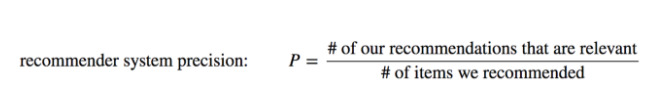

In [190]:
2/10

0.2

Dari kode diatas maka presisi yg di dapat yaitu 20%

##Collaborative Filtered Recommendation System

Goal proyek  Collaborative Filtered kali ini adalah menghasilkan rekomendasi sejumlah restoran yang sesuai dengan preferensi pengguna berdasarkan rating yang telah diberikan sebelumnya. Dari data rating pengguna, kita akan mengidentifikasi restoran-restoran yang mirip dan belum pernah dikunjungi oleh pengguna untuk direkomendasikan. Kita akan menggunakan teknik collaborative filtering untuk membuat rekomendasi ini.

Kelebihan pada Collaborative Based Filtering bila dibandingkan dengan Content Based Filtering adalah pengguna dapat mengeksplorasi item atau konten di luar preferensi pengguna. Pengguna pun juga dapat mendapat rekomendasi sesuai dengan kecenderungan publik yang dianalisa lewat penilaian pengguna - pengguna lainnya.

Kekurangan pada Collaborative Based Filtering adalah pengguna kurang mendapatkan rekomendasi sesuai preferensi pribadi. Konten - konten yang diberikan oleh sistem rekomendasi lebih banyak berasal dari preferensi publik dan bukan preferensi pribadi.

**Investor akan mencari rekomendasi restoran yang sesuai preferensi tipe restoran yang dia sukai dengan mengetahui type restoran apa yang ingin dibuka, kemudian sistem akan merekomendasikan restoran serupa dengan inforamasi lokasi dan jenis makanan yang potensial berdasarkan rating terbaik**

###FEATURE ENGINEERING

In [191]:
dfresto

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23417,https://www.zomato.com/bangalore/izakaya-gastr...,"2nd Floor, Iona, Virginia Mall, Whitefield Mai...",Izakaya Gastro Pub,Yes,Yes,3.8,128,+91 7625087121\n+91 8050587483,Whitefield,"Bar, Casual Dining","Beer, Chicken Guntur, Paneer Tikka, Fish, Nood...","North Indian, Continental, Mediterranean",1.2,"[('Rated 3.0', ""RATED\n Nice place to hangout...",[],Pubs and bars,Whitefield
23418,https://www.zomato.com/bangalore/m-bar-bengalu...,"Bengaluru Marriott Hotel, 75, 8th Road, EPIP A...",M Bar - Bengaluru Marriott Hotel Whitefield,No,No,3.9,77,080 49435000,Whitefield,"Fine Dining, Bar",Rooftop Ambience,Finger Food,2.0,"[('Rated 4.0', 'RATED\n Went there post dinne...",[],Pubs and bars,Whitefield
23419,https://www.zomato.com/bangalore/keys-cafe-key...,"Keys Hotel, 6, 1st Phase Industrial Area, Near...",Keys Cafe - Keys Hotel,No,No,2.8,161,080 39451000\n+91 8884038484,Whitefield,"Casual Dining, Bar","Salads, Coffee, Breakfast Buffet, Halwa, Chick...","Chinese, Continental, North Indian",1.2,"[('Rated 3.0', 'RATED\n Place is good not tha...",[],Pubs and bars,Whitefield
23420,https://www.zomato.com/bangalore/bhagini-2-whi...,"139/C1, Next To GR Tech Park, Pattandur Agraha...",Bhagini,No,No,2.5,81,080 65951222,Whitefield,"Casual Dining, Bar","Biryani, Andhra Meal","Andhra, South Indian, Chinese, North Indian",800.0,"[('Rated 4.0', 'RATED\n A fine place to chill...",[],Pubs and bars,Whitefield


In [192]:
resto_name = dfresto['name'].tolist()
resto_type = dfresto['rest_type'].tolist()
resto_dish_liked = dfresto['dish_liked'].tolist()
resto_cuisines = dfresto['cuisines'].tolist()
resto_location = dfresto['location'].tolist()
resto_city = dfresto['city'].tolist()
resto_address = dfresto['address'].tolist()
resto_rate= dfresto['rate'].tolist()

In [194]:
resto = pd.DataFrame({
    'resto_name': resto_name,
    'resto_type': resto_type,
    'resto_dish_liked': resto_dish_liked,
    'resto_cuisines': resto_cuisines,
    'resto_location': resto_location,
    'resto_city': resto_city,
    'resto_address':resto_address,
    'resto_rate':resto_rate
})
resto.head()

,resto_name,resto_type,resto_dish_liked,resto_cuisines,resto_location,resto_city,resto_address,resto_rate
0,Jalsa,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",Banashankari,Banashankari,"942, 21st Main Road, 2nd Stage, Banashankari, ...",4.1
1,Spice Elephant,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",Banashankari,Banashankari,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",4.1
2,San Churro Cafe,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",Banashankari,Banashankari,"1112, Next to KIMS Medical College, 17th Cross...",3.8
3,Addhuri Udupi Bhojana,Quick Bites,Masala Dosa,"South Indian, North Indian",Banashankari,Banashankari,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",3.7
4,Grand Village,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",Basavanagudi,Banashankari,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",3.8


####Data Preparation

#####Rubah koma dalam datasetmenjadi &

In [195]:
resto.resto_type  = resto.resto_type.apply(lambda x: x.replace(',',' & '))

#####Drop Duplicated

In [196]:
resto = resto.drop_duplicates('resto_name')

In [197]:
resto.head()

,resto_name,resto_type,resto_dish_liked,resto_cuisines,resto_location,resto_city,resto_address,resto_rate
0,Jalsa,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",Banashankari,Banashankari,"942, 21st Main Road, 2nd Stage, Banashankari, ...",4.1
1,Spice Elephant,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",Banashankari,Banashankari,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",4.1
2,San Churro Cafe,Cafe & Casual Dining,"Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",Banashankari,Banashankari,"1112, Next to KIMS Medical College, 17th Cross...",3.8
3,Addhuri Udupi Bhojana,Quick Bites,Masala Dosa,"South Indian, North Indian",Banashankari,Banashankari,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",3.7
4,Grand Village,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",Basavanagudi,Banashankari,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",3.8


In [198]:
resto.resto_name.duplicated().sum()

0

In [199]:
resto.duplicated().sum()

0

In [200]:
resto.columns

Index(['resto_name', 'resto_type', 'resto_dish_liked', 'resto_cuisines',
       'resto_location', 'resto_city', 'resto_address', 'resto_rate'],
      dtype='object')

In [201]:
resto.isnull().any() .isnull().sum() 

0

In [202]:
resto.dropna(inplace=True)

In [203]:
resto.isnull().any() .isnull().sum() 

0

#####Ubah kolom ke numeric

In [204]:
# Ubah kedalam bentuk numerik
encoded_data = LabelEncoder()

resto['resto_type_id'] = encoded_data.fit_transform(resto['resto_type'])
resto['resto_location_id'] = encoded_data.fit_transform(resto['resto_location'])

resto.head()

,resto_name,resto_type,resto_dish_liked,resto_cuisines,resto_location,resto_city,resto_address,resto_rate,resto_type_id,resto_location_id
0,Jalsa,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",Banashankari,Banashankari,"942, 21st Main Road, 2nd Stage, Banashankari, ...",4.1,20,1
1,Spice Elephant,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",Banashankari,Banashankari,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",4.1,20,1
2,San Churro Cafe,Cafe & Casual Dining,"Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",Banashankari,Banashankari,"1112, Next to KIMS Medical College, 17th Cross...",3.8,16,1
3,Addhuri Udupi Bhojana,Quick Bites,Masala Dosa,"South Indian, North Indian",Banashankari,Banashankari,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",3.7,60,1
4,Grand Village,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",Basavanagudi,Banashankari,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",3.8,20,4


In [ ]:
# scaler = StandardScaler()
# resto['resto_type_id_scale'] = scaler.fit_transform(resto['resto_type_id'].values.reshape(-1,1))
# resto['resto_location_id_scale'] = scaler.fit_transform(resto['resto_location_id'].values.reshape(-1,1))
# resto['resto_rate_scale'] = scaler.fit_transform(resto['resto_rate'].values.reshape(-1,1))
# resto

#####Encode Type Restoran

In [205]:
# Mengubah resto_type menjadi list tanpa nilai yang sama
resto_types = resto['resto_type_id'].unique().tolist()
print('list resto tipe: ', resto_types)
 
# Melakukan encoding resto_type
resto_to_resto_type_encoded = {x: i for i, x in enumerate(resto_types)}
print('encoded reto tipe : ', resto_to_resto_type_encoded)
 
# Melakukan proses encoding angka ke ke tipe restoran
resto_encoded_to_resto_type = {i: x for i, x in enumerate(resto_types)}
print('encoded angka ke resto_type: ', resto_encoded_to_resto_type)

list resto tipe:  [20, 16, 60, 22, 13, 63, 29, 30, 55, 9, 4, 69, 42, 64, 58, 21, 0, 66, 32, 12, 52, 67, 44, 39, 14, 50, 43, 56, 26, 19, 45, 3, 34, 5, 11, 25, 49, 47, 17, 33, 2, 68, 54, 27, 35, 1, 10, 57, 23, 62, 37, 65, 61, 8, 59, 53, 38, 36, 15, 24, 51, 41, 18, 7, 46, 31, 28, 48, 6, 40]
encoded reto tipe :  {20: 0, 16: 1, 60: 2, 22: 3, 13: 4, 63: 5, 29: 6, 30: 7, 55: 8, 9: 9, 4: 10, 69: 11, 42: 12, 64: 13, 58: 14, 21: 15, 0: 16, 66: 17, 32: 18, 12: 19, 52: 20, 67: 21, 44: 22, 39: 23, 14: 24, 50: 25, 43: 26, 56: 27, 26: 28, 19: 29, 45: 30, 3: 31, 34: 32, 5: 33, 11: 34, 25: 35, 49: 36, 47: 37, 17: 38, 33: 39, 2: 40, 68: 41, 54: 42, 27: 43, 35: 44, 1: 45, 10: 46, 57: 47, 23: 48, 62: 49, 37: 50, 65: 51, 61: 52, 8: 53, 59: 54, 53: 55, 38: 56, 36: 57, 15: 58, 24: 59, 51: 60, 41: 61, 18: 62, 7: 63, 46: 64, 31: 65, 28: 66, 48: 67, 6: 68, 40: 69}
encoded angka ke resto_type:  {0: 20, 1: 16, 2: 60, 3: 22, 4: 13, 5: 63, 6: 29, 7: 30, 8: 55, 9: 9, 10: 4, 11: 69, 12: 42, 13: 64, 14: 58, 15: 21, 16

#####Encode fitur ‘Lokasi’.

In [206]:
# Mengubah placeID menjadi list tanpa nilai yang sama
resto_location = resto['resto_location_id'].unique().tolist()
 
# Melakukan proses encoding lokasi
resto_to_resto_location_encoded = {x: i for i, x in enumerate(resto_location)}
 
# Melakukan proses encoding angka ke lokasi
resto_encoded_to_resto_location = {i: x for i, x in enumerate(resto_location)}

##### Berikutnya, petakan tiperesto dan location ke dataframe yang berkaitan.

In [207]:
# Mapping tipe restoran ke dataframe resto
resto['tipe_resto'] = resto['resto_type_id'].map(resto_to_resto_type_encoded)
 
# Mapping placeID ke dataframe resto
resto['lokasi_resto'] = resto['resto_location_id'].map(resto_to_resto_location_encoded)

#####cek beberapa hal dalam data seperti jumlah tipe restora, jumlah lokasi, dan mengubah nilai rating menjadi float.

In [208]:
resto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3166 entries, 0 to 23363
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   resto_name         3166 non-null   object 
 1   resto_type         3166 non-null   object 
 2   resto_dish_liked   3166 non-null   object 
 3   resto_cuisines     3166 non-null   object 
 4   resto_location     3166 non-null   object 
 5   resto_city         3166 non-null   object 
 6   resto_address      3166 non-null   object 
 7   resto_rate         3166 non-null   float64
 8   resto_type_id      3166 non-null   int64  
 9   resto_location_id  3166 non-null   int64  
 10  tipe_resto         3166 non-null   int64  
 11  lokasi_resto       3166 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 321.5+ KB


In [209]:
# Mendapatkan jumlah resto type
num_resto_type = len(resto_to_resto_type_encoded)
print(num_resto_type)
 
# Mendapatkan jumlah lokasi
num_resto_location = len(resto_encoded_to_resto_location)
print(num_resto_location)
 
# Nilai minimum rating
min_rating = min(resto['resto_rate'])
 
# Nilai maksimal rating
max_rating = max(resto['resto_rate'])
 
print('Number of tipe resto: {}, Number of lokasi Resto: {}, Min Rating: {}, Max Rating: {}'.format(
    num_resto_type, num_resto_location, min_rating, max_rating
))

70
85
Number of tipe resto: 70, Number of lokasi Resto: 85, Min Rating: 1.8, Max Rating: 4.9


#####Membagi Data untuk Training dan Validasi

 Acak datanya terlebih dahulu agar distribusinya menjadi random

In [210]:
# Mengacak dataset
resto = resto.sample(frac=1, random_state=42)
resto

,resto_name,resto_type,resto_dish_liked,resto_cuisines,resto_location,resto_city,resto_address,resto_rate,resto_type_id,resto_location_id,tipe_resto,lokasi_resto
1025,Pani Kum Chai,Quick Bites,"Chai, Lemon Tea, Chicken Roll",Fast Food,Jayanagar,Basavanagudi,"Swagath Main Road, Near Garuda Mall, Jayanagar...",3.9,60,29,2,2
3032,Bloomsbury's Global Kitchen & Bakehouse,Cafe & Dessert Parlor,"Pizza, Cheesecake, Burgers, Pasta, Waffles, Ch...","American, Cafe, Continental, French, Burger, M...",Whitefield,Brookefield,"Ground Floor, EPIP Zone, Near BMTC Bus Depot, ...",4.5,17,81,38,48
185,Eurasia Pasta and Barbeque by Little Italy,Casual Dining & Bar,"Pasta, Pizza, Nachos, Gelato, Ravioli, Jalapen...","Italian, Fast Food, Salad, BBQ",Jayanagar,Banashankari,"12, 32nd Cross, 7th Block, Jayanagar, Bangalore",4.1,21,29,15,2
23308,Squeez Juice Bar,Food Court,"Watermelon Juice, Malai Kulfi","Juices, Fast Food",Whitefield,Whitefield,"2nd Floor, Food Court, Phoenix Market City Mal...",3.8,39,81,23,48
3819,Vegan Heat,Takeaway & Delivery,"Burgers, Pancakes, Waffles, Salad","Healthy Food, Salad",Koramangala 1st Block,BTM,"178/10, 3rd B Cross, Venkatapura Main Road, Ko...",4.1,69,37,11,23
...,...,...,...,...,...,...,...,...,...,...,...,...
22885,Red Rhino,Microbrewery & Pub,"Beer, Margarita, Long Island Iced Tea, Cocktai...","Continental, Mediterranean, South Indian, Nort...",Whitefield,Whitefield,"4th Floor, Uptown Square, Seegehalli, Near All...",4.4,54,81,42,48
2336,Gelato Italiano,Dessert Parlor,"Belgian Chocolate, Waffle Cone, Tiramisu","Ice Cream, Bakery, Desserts",Brigade Road,Brigade Road,"Ground Floor, Garuda Mall, Magrath Road, Ashok...",3.0,30,8,7,26
2390,Fujan,Casual Dining,Chicken Noodle,"Chinese, Thai, Seafood",Frazer Town,Brigade Road,"68, MM Road, Near Mosque, Frazer Town, Bangalore",3.6,20,19,0,42
2853,Sweet Chariot Cafe,Dessert Parlor,"Chocolate Mousse, Pasta, Chocolate Cake, Lemon...","Continental, Fast Food, Beverages, Desserts",Residency Road,Brigade Road,"15/2, Near Bishop Cotton's Boys School, Reside...",3.8,30,63,7,30


Selanjutnya, kita bagi data train dan validasi dengan komposisi **80:20**. Namun sebelumnya, kita perlu memetakan (mapping) data tipe resto dan lokasi resto menjadi satu value terlebih dahulu. Lalu, dibuat rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training. 

In [211]:
# Membuat variabel x untuk mencocokkan data tipe reso dan resto menjadi satu value
x = resto[['tipe_resto', 'lokasi_resto']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = resto['resto_rate'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * resto.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[ 2  2]
 [38 48]
 [15  2]
 ...
 [ 0 42]
 [ 7 30]
 [ 6 17]] [0.67741935 0.87096774 0.74193548 ... 0.58064516 0.64516129 0.64516129]


In [212]:
 resto[['tipe_resto', 'lokasi_resto','resto_rate']].max()

tipe_resto      69.0
lokasi_resto    84.0
resto_rate       4.9
dtype: float64

In [213]:
resto.shape

(3166, 12)

###Modeling

####Embeding

Pada tahap ini, model menghitung skor kecocokan antara tipe resto dan lokasi resto dengan teknik embedding. Pertama, kita melakukan proses embedding terhadap data tipe resto dan lokasi resto. Selanjutnya, operasi perkalian dot product antara embedding tipe resto dan lokasi resto. Selain itu, kita juga dapat menambahkan bias untuk setiap tipe dan lokasi. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

Di sini, kita membuat class RecommenderNet dengan keras Model class.

In [214]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_resto_type, num_resto_location, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_resto_type = num_resto_type
    self.num_resto_location = num_resto_location
    self.embedding_size = embedding_size
    self.restotype_embedding = layers.Embedding( # layer embedding tipe resto
        num_resto_type,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.restotype_bias = layers.Embedding(num_resto_type, 1) # layer embedding tipe resto bias
    self.restolocation_embedding = layers.Embedding( # layer embeddings resto location
        num_resto_location,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.restolocation_bias = layers.Embedding(num_resto_location, 1) # layer embedding resto location bias
 
  def call(self, inputs):
    resto_type_vector = self.restotype_embedding(inputs[:,0]) # memanggil layer embedding 1
    resto_type_bias = self.restotype_bias(inputs[:, 0]) # memanggil layer embedding 2
    restolocation_vector = self.restolocation_embedding(inputs[:, 1]) # memanggil layer embedding 3
    restolocation_bias = self.restolocation_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_resto_location = tf.tensordot(resto_type_vector, restolocation_vector, 2) 
 
    x = dot_resto_location + resto_type_bias + restolocation_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

Selanjutnya, lakukan proses compile terhadap model.

In [215]:
model = RecommenderNet(num_resto_type, num_resto_location, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Model ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation. 

####Training & Evaluation

In [216]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 5,
    epochs=20,
    validation_data = (x_val, y_val)
)

Epoch 1/20
507/507 [==============================] - 3s 5ms/step - loss: 0.6605 - root_mean_squared_error: 0.1706 - val_loss: 0.6533 - val_root_mean_squared_error: 0.1503
Epoch 2/20
507/507 [==============================] - 2s 4ms/step - loss: 0.6425 - root_mean_squared_error: 0.1427 - val_loss: 0.6487 - val_root_mean_squared_error: 0.1432
Epoch 3/20
507/507 [==============================] - 2s 4ms/step - loss: 0.6386 - root_mean_squared_error: 0.1365 - val_loss: 0.6442 - val_root_mean_squared_error: 0.1361
Epoch 4/20
507/507 [==============================] - 2s 4ms/step - loss: 0.6359 - root_mean_squared_error: 0.1321 - val_loss: 0.6438 - val_root_mean_squared_error: 0.1355
Epoch 5/20
507/507 [==============================] - 2s 4ms/step - loss: 0.6343 - root_mean_squared_error: 0.1293 - val_loss: 0.6432 - val_root_mean_squared_error: 0.1345
Epoch 6/20
507/507 [==============================] - 3s 5ms/step - loss: 0.6326 - root_mean_squared_error: 0.1264 - val_loss: 0.6438 - val_

**Visualisasi Metrik**

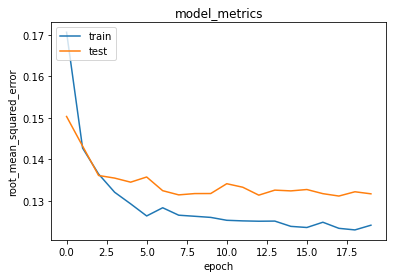

In [217]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

proses training model cukup smooth dan model konvergen pada epochs sekitar 20. Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.12 dan error pada data validasi sebesar 0.13. Nilai tersebut cukup bagus untuk sistem rekomendasi

####**Mendapatkan Rekomendasi Resto**

In [218]:
resto.head(2)

,resto_name,resto_type,resto_dish_liked,resto_cuisines,resto_location,resto_city,resto_address,resto_rate,resto_type_id,resto_location_id,tipe_resto,lokasi_resto
1025,Pani Kum Chai,Quick Bites,"Chai, Lemon Tea, Chicken Roll",Fast Food,Jayanagar,Basavanagudi,"Swagath Main Road, Near Garuda Mall, Jayanagar...",3.9,60,29,2,2
3032,Bloomsbury's Global Kitchen & Bakehouse,Cafe & Dessert Parlor,"Pizza, Cheesecake, Burgers, Pasta, Waffles, Ch...","American, Cafe, Continental, French, Burger, M...",Whitefield,Brookefield,"Ground Floor, EPIP Zone, Near BMTC Bus Depot, ...",4.5,17,81,38,48


In [221]:
# Mengambil sample resto type
resto_type_id = resto.resto_type_id.sample(1).iloc[0]
resto_visited_by_user = resto[resto.resto_type_id == resto_type_id]
 
# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html 
resto_not_visited = resto[~resto['resto_type_id'].isin(resto_visited_by_user.resto_type_id.values)]['resto_type_id'] 
resto_not_visited = list(
    set(resto_not_visited)
    .intersection(set(resto_to_resto_location_encoded.keys()))
)
 
resto_not_visited = [[resto_to_resto_location_encoded.get(x)] for x in resto_not_visited]
resto_encoder = resto_to_resto_type_encoded.get(resto_type_id)
resto_resto_array = np.hstack(
    ([[resto_encoder]] * len(resto_not_visited), resto_not_visited)
)

In [225]:
ratings = model.predict(resto_resto_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_resto_ids = [
    resto_encoded_to_resto_location.get(resto_not_visited[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for resto_type_id: {}'.format(resto_type_id))
print('===' * 9)
print('Resto with high ratings from user')
print('----' * 8)
 
top_resto_user = (
    resto_visited_by_user.sort_values(
        by = 'resto_rate',
        ascending=False
    )
    .head(5)
    .resto_location_id.values
)
 
resto_df_rows = resto[resto['resto_type_id'].isin(top_resto_user)]
# for row in resto_df_rows.sort_values(by='resto_rate',ascending=False).head().itertuples():
#     print(row.resto_name, ':', row.resto_cuisines,'. Rating:', row.resto_rate,'.Resto Type:', row.resto_type,', Location: ',row.resto_location, '. Dish Like:',row.resto_dish_liked)
resto_df_rows.sort_values(by='resto_rate',ascending=False).head()


Showing recommendations for resto_type_id: 13
Resto with high ratings from user
--------------------------------


,resto_name,resto_type,resto_dish_liked,resto_cuisines,resto_location,resto_city,resto_address,resto_rate,resto_type_id,resto_location_id,tipe_resto,lokasi_resto
3613,Asia Kitchen By Mainland China,Casual Dining & Bar,"Noodles, Chicken Dim Sum, Pad Thai Noodle, Jum...","Asian, Chinese, Thai, Momos",Koramangala 5th Block,BTM,"136, Ground Floor, 1st Cross, 5th Block, Jyoti...",4.9,21,41,15,13
1534,The Black Pearl,Casual Dining & Bar,"Dahipuri, Jal-jeera, Chicken Grill, Mutton See...","North Indian, European, Mediterranean, BBQ",Marathahalli,Bellandur,"20/7, Swamy Legato, Outer Ring Road, Kadubeesa...",4.8,21,52,15,19
7369,TBC Sky Lounge,Casual Dining & Bar,"Kulcha, Cocktails, Peri Peri Chicken, Masala P...","Continental, Asian, Italian, North Indian",HSR,HSR,"Astra Hotel, 2795, 27th Main, Sector 1, HSR, B...",4.7,21,21,15,20
6,Onesta,Casual Dining & Cafe,"Farmhouse Pizza, Chocolate Banana, Virgin Moji...","Pizza, Cafe, Italian",Banashankari,Banashankari,"2469, 3rd Floor, 24th Cross, Opposite BDA Comp...",4.6,22,1,3,0
2356,MISU,Casual Dining & Bar,"Sushi, Dumplings, Khau Suey, Noodles, Cocktail...","Asian, Japanese, Korean, Indonesian, Malaysian...",St. Marks Road,Brigade Road,"4th Floor, Building 9, Halcyon Complex, St. Ma...",4.6,21,74,15,33


In [229]:
print('----' * 8)
print('Top 5 resto recommendation')
print('----' * 8)
 
recommended_resto = resto[resto['resto_type_id'].isin(recommended_resto_ids)].head()
# for row in recommended_resto.itertuples():
#     print(row.resto_name, ':', row.resto_cuisines,'Resto Type:', row.resto_type,', Location: ',row.resto_location, '. Dish Like:',row.resto_dish_liked)
recommended_resto.sort_values(by='resto_rate',ascending=False).head()

--------------------------------
Top 5 resto recommendation
--------------------------------


,resto_name,resto_type,resto_dish_liked,resto_cuisines,resto_location,resto_city,resto_address,resto_rate,resto_type_id,resto_location_id,tipe_resto,lokasi_resto
3171,Cakesta,Bakery,"Eggless Cake, Choco Mocha, Choco Almond, Blueb...","Bakery, Desserts","ITPL Main Road, Whitefield",Brookefield,"Ascendas Park Square, ITPL Main Road, Whitefield",4.1,0,24,16,49
626,Bread Crumbs Bakery,Bakery,"Samosa, Egg Puff, Paneer Puff, Chocolate Truffle","Desserts, Bakery",Bannerghatta Road,Bannerghatta Road,"989, Ambika Corner, DC Road, Off Bannerghatta ...",4.0,0,3,16,9
7132,Cake Cafe,Bakery,Blueberry Cake,"Bakery, Desserts",HSR,HSR,"Garden Layout Road, Sector 2, HSR Layout, HSR,...",4.0,0,21,16,20
7339,L J Iyengar Bakery,Bakery,"Fruit Cake, Chocolate Cake, Egg Puff",Bakery,HSR,HSR,"530, 24th Main, Sector 2, HSR Layout, HSR, Ban...",3.9,0,21,16,20
3987,Kwality Cakes N Bakes,Bakery,"Eggless Cake, Burgers, Red Velvet Cake","Bakery, Desserts",HSR,BTM,"Shop 355/1 14th B Cross, Sector 6, HSR, Bangalore",3.7,0,21,16,20


System rekomendasi diatas menampilkan rekomendasi type resto yang belum pernah dikunjungi oleh investor/bukan pilihan investor. dalam kasus ini investor ingin membuka usaha dan mendapatkan rekomendasi sesuai tipe restoran yang dia sukai, maka dapat menggunakan **Showing recommendations for users**.

**Temukan rekomendasi sesuai dengan tipe restoran yang ingin dibuka oleh investor**

In [230]:
# Mengambil sample resto type
resto_type_id = resto.resto_type_id.sample(1).iloc[0]
resto_visited_by_user = resto[resto.resto_type_id == resto_type_id]
 
# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html 
resto_visited = resto[resto['resto_type_id'].isin(resto_visited_by_user.resto_type_id.values)]['resto_type_id'] 
resto_visited = list(
    set(resto_visited)
    .intersection(set(resto_to_resto_location_encoded.keys()))
)
 
resto_visited = [[resto_to_resto_location_encoded.get(x)] for x in resto_visited]
resto_encoder = resto_to_resto_type_encoded.get(resto_type_id)
resto_resto_array = np.hstack(
    ([[resto_encoder]] * len(resto_visited), resto_visited)
)

ratings = model.predict(resto_resto_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_resto_ids = [
    resto_encoded_to_resto_location.get(resto_not_visited[x][0]) for x in top_ratings_indices
]
 
print('----' * 8)
print('Top 5 resto recommendation')
print('----' * 8)
 
recommended_resto = resto[resto['resto_type_id'].isin(recommended_resto_ids)].head()
# for row in recommended_resto.itertuples():
#     print(row.resto_name, ':', row.resto_cuisines,'Resto Type:', row.resto_type,', Location: ',row.resto_location, '. Dish Like:',row.resto_dish_liked)
recommended_resto.sort_values(by='resto_rate',ascending=False).head()
 

--------------------------------
Top 5 resto recommendation
--------------------------------


,resto_name,resto_type,resto_dish_liked,resto_cuisines,resto_location,resto_city,resto_address,resto_rate,resto_type_id,resto_location_id,tipe_resto,lokasi_resto
3171,Cakesta,Bakery,"Eggless Cake, Choco Mocha, Choco Almond, Blueb...","Bakery, Desserts","ITPL Main Road, Whitefield",Brookefield,"Ascendas Park Square, ITPL Main Road, Whitefield",4.1,0,24,16,49
626,Bread Crumbs Bakery,Bakery,"Samosa, Egg Puff, Paneer Puff, Chocolate Truffle","Desserts, Bakery",Bannerghatta Road,Bannerghatta Road,"989, Ambika Corner, DC Road, Off Bannerghatta ...",4.0,0,3,16,9
7132,Cake Cafe,Bakery,Blueberry Cake,"Bakery, Desserts",HSR,HSR,"Garden Layout Road, Sector 2, HSR Layout, HSR,...",4.0,0,21,16,20
7339,L J Iyengar Bakery,Bakery,"Fruit Cake, Chocolate Cake, Egg Puff",Bakery,HSR,HSR,"530, 24th Main, Sector 2, HSR Layout, HSR, Ban...",3.9,0,21,16,20
3987,Kwality Cakes N Bakes,Bakery,"Eggless Cake, Burgers, Red Velvet Cake","Bakery, Desserts",HSR,BTM,"Shop 355/1 14th B Cross, Sector 6, HSR, Bangalore",3.7,0,21,16,20
